# 4.2 MEV Router Frequency Analysis

In this notebook, we analyze **router-level activity patterns** to detect MEV bots.

Routers include:

- Uniswap V2 Router  
- Uniswap V3 Router  
- 1inch Aggregator  
- 0x Exchange Proxy  
- ParaSwap Router  
- Other swap contracts

MEV bots often:

- Interact heavily with routers  
- Invoke multiple routers in the same hour  
- Exhibit abnormal frequency compared to normal addresses

This notebook extracts these signals for later integration in Chapter 4.


## 1. Imports + Load Data

We load the cleaned transactions `tx` and extract
router-related contract interactions.

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(PROJECT_ROOT)

from src.data.load_data import load_clean_transactions

In [3]:
# Load transaction data
tx = load_clean_transactions()
print("Transactions:", len(tx))

tx.head()


Transactions: 13268


,hash,from_address,to_address,block_number,value,block_timestamp
0,0xd8ec648861cf4de73f18f9a034623eeded1b26ec7246...,0xa9264494a92ced04747ac84fc9ca5a0b9549b491,0x835033bd90b943fa0d0f8e5382d9dc568d3fbd96,23772289,4.699994e+19,2025-11-11 00:00:11+00:00
1,0x5843a9e865f9b7222ddb376ea2869c50b389c3a0d858...,0xc0ffeebabe5d496b2dde509f9fa189c25cf29671,0xc0ffeebabe5d496b2dde509f9fa189c25cf29671,23772292,5.817089e+19,2025-11-11 00:00:47+00:00
2,0x131571aec26cd23b0134a97341acf9fb0b559b085b68...,0xe50008c1d110da8e56982f46a9188a292ee90a7b,0x1ab4973a48dc892cd9971ece8e01dcc7688f8f23,23772292,3.390013e+18,2025-11-11 00:00:47+00:00
3,0xa1b7caf05dd498111a40ffe269fefb2ae574dde53da0...,0xe40d548eb4fa4d9188fd21723f2fd377456c0876,0x28c6c06298d514db089934071355e5743bf21d60,23772292,7.999922e+18,2025-11-11 00:00:47+00:00
4,0xc1d8e4ffa9e7864d5a38f84aa4532308d411ba35f82e...,0x0eb1665de6473c624dcd087fdeee27418d65ed59,0xa03400e098f4421b34a3a44a1b4e571419517687,23772292,6.318854e+18,2025-11-11 00:00:47+00:00


## 2. Identify Router Contracts

We detect contract addresses that are known DEX routers.

Typical routers include:

- Uniswap V2 Router  
- Uniswap V3 SwapRouter  
- 1inch Aggregation Router  
- ParaSwap Router  
- 0x Exchange Proxy

If ABI labels exist in the dataset, we use them; otherwise, we maintain
a manually curated list.

In [10]:
# Example router address list (placeholder — update with your actual dataset)
router_addresses = {
    "uniswap_v2": [
        "0xf164fc0ec4e93095b804a4795bbe1e041497b92a",
    ],
    "uniswap_v3": [
        "0xe592427a0aece92de3edee1f18e0157c05861564",
    ],
    "1inch": [
        "0x1111111254eeb25477b68fb85ed929f73a960582",
    ],
    "0x_exchange": [
        "0xdef1c0ded9bec7f1a1670819833240f027b25eff",
    ],
    "paraswap": [
        "0xdef171fe48cf0115b1d80b88dc8eab59176fee57",
    ],
    "sushi_swap": [
        "0xd9e1ce17f2641f24ae83637ab66a2cca9c378b9f",
    ],
    "balancer": [
        "0xba12222222228d8ba445958a75a07044adaf5ab",
    ],
    "curve": [
        "0x11111112542d85b3ef69ae05771c22d518637fe",
    ],
    "kyber_swap": [
        "0x1c87257f5e8609940bc751a07bb5c9c3e1b0b76",
    ]
}

router_all = set([a.lower() for lst in router_addresses.values() for a in lst])
print("Total unique router addresses:", len(router_all))



Total unique router addresses: 9


## 3. Filter Router Interactions

We mark whether each transaction involves a known router.


In [18]:
tx["to_address_lower"] = tx["to_address"].str.lower()

tx["is_router_tx"] = tx["to_address_lower"].isin(router_all)
tx["router_type"] = None

for router_name, addr_list in router_addresses.items():
    addr_set = set([a.lower() for a in addr_list])
    mask = tx["to_address_lower"].isin(addr_set)
    tx.loc[mask, "router_type"] = router_name

tx.head()



,hash,from_address,to_address,block_number,value,block_timestamp,to_address_lower,is_router_tx,router_type,datetime,hour
0,0xd8ec648861cf4de73f18f9a034623eeded1b26ec7246...,0xa9264494a92ced04747ac84fc9ca5a0b9549b491,0x835033bd90b943fa0d0f8e5382d9dc568d3fbd96,23772289,4.699994e+19,2025-11-11 00:00:11+00:00,0x835033bd90b943fa0d0f8e5382d9dc568d3fbd96,False,None,2025-11-11 00:00:11+00:00,2025-11-11 00:00:00+00:00
1,0x5843a9e865f9b7222ddb376ea2869c50b389c3a0d858...,0xc0ffeebabe5d496b2dde509f9fa189c25cf29671,0xc0ffeebabe5d496b2dde509f9fa189c25cf29671,23772292,5.817089e+19,2025-11-11 00:00:47+00:00,0xc0ffeebabe5d496b2dde509f9fa189c25cf29671,False,None,2025-11-11 00:00:47+00:00,2025-11-11 00:00:00+00:00
2,0x131571aec26cd23b0134a97341acf9fb0b559b085b68...,0xe50008c1d110da8e56982f46a9188a292ee90a7b,0x1ab4973a48dc892cd9971ece8e01dcc7688f8f23,23772292,3.390013e+18,2025-11-11 00:00:47+00:00,0x1ab4973a48dc892cd9971ece8e01dcc7688f8f23,False,None,2025-11-11 00:00:47+00:00,2025-11-11 00:00:00+00:00
3,0xa1b7caf05dd498111a40ffe269fefb2ae574dde53da0...,0xe40d548eb4fa4d9188fd21723f2fd377456c0876,0x28c6c06298d514db089934071355e5743bf21d60,23772292,7.999922e+18,2025-11-11 00:00:47+00:00,0x28c6c06298d514db089934071355e5743bf21d60,False,None,2025-11-11 00:00:47+00:00,2025-11-11 00:00:00+00:00
4,0xc1d8e4ffa9e7864d5a38f84aa4532308d411ba35f82e...,0x0eb1665de6473c624dcd087fdeee27418d65ed59,0xa03400e098f4421b34a3a44a1b4e571419517687,23772292,6.318854e+18,2025-11-11 00:00:47+00:00,0xa03400e098f4421b34a3a44a1b4e571419517687,False,None,2025-11-11 00:00:47+00:00,2025-11-11 00:00:00+00:00


## 4. Router Usage Frequency (Hourly)

MEV bots often fire transactions through routers *many times per hour*.

We count:

- Actions per router  
- Actions per address per router  
- Aggregate hourly patterns


In [12]:
tx["datetime"] = pd.to_datetime(tx["block_timestamp"])
tx["hour"] = tx["datetime"].dt.floor("H")

router_hourly = (
    tx[tx["is_router_tx"]]
    .groupby(["router_type", "hour"])["hash"]
    .count()
    .rename("tx_count")
    .reset_index()
)

router_hourly.head()

/var/folders/tm/2mpx1bkj39x81n32__pl6vbw0000gn/T/ipykernel_1374/1546074819.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tx["hour"] = tx["datetime"].dt.floor("H")


,router_type,hour,tx_count
0,1inch,2025-11-11 01:00:00+00:00,1
1,1inch,2025-11-11 03:00:00+00:00,1
2,1inch,2025-11-11 04:00:00+00:00,1
3,1inch,2025-11-11 11:00:00+00:00,1
4,1inch,2025-11-11 19:00:00+00:00,1


### 4.1 Plot Router Activity Over Time

<Figure size 1400x500 with 0 Axes>

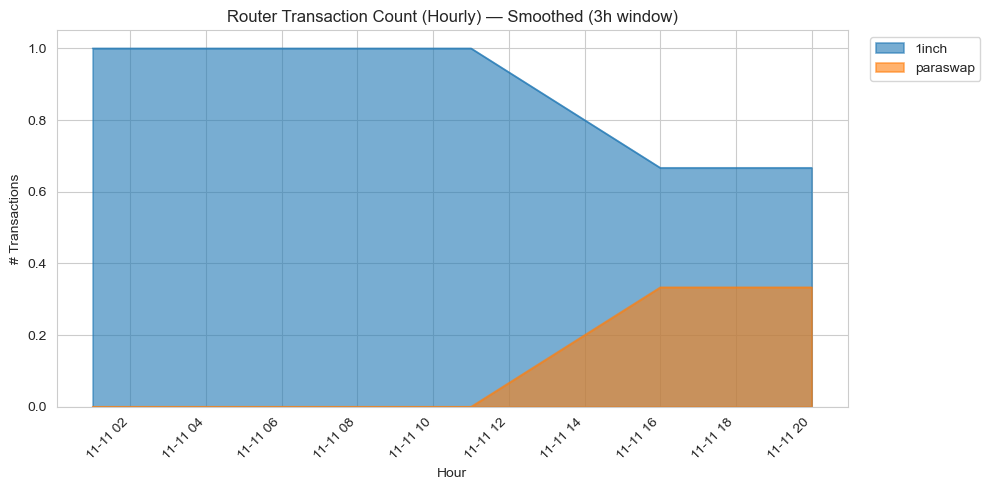

/var/folders/tm/2mpx1bkj39x81n32__pl6vbw0000gn/T/ipykernel_1374/654101156.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=totals.values, y=totals.index, palette='viridis')


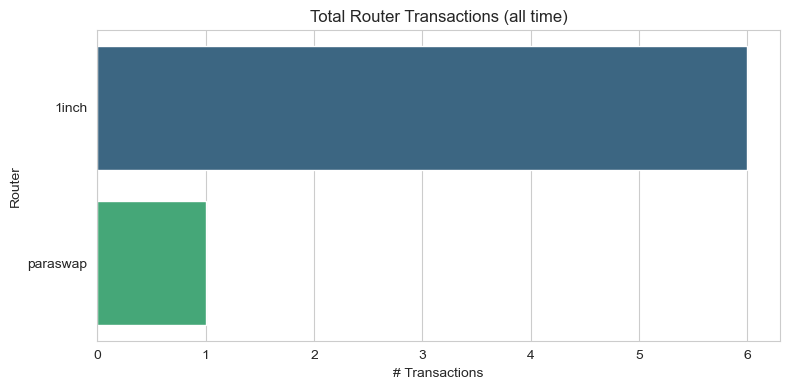

In [24]:
import seaborn as sns
sns.set_style('whitegrid')

# Pivot to wide format (hours x router_type)
df = router_hourly.pivot(index='hour', columns='router_type', values='tx_count').fillna(0)

# If only a couple of routers, use area (stacked=False) or bar to make visual clearer
n_routers = df.shape[1]

# Smooth with short rolling mean to reduce noise (window in hours)
df_smooth = df.rolling(window=3, min_periods=1).mean()

plt.figure(figsize=(14, 5))
if n_routers <= 3:
    # area plot for small number of series (clear and compact)
    df_smooth.plot(kind='area', stacked=False, alpha=0.6, linewidth=1.2)
    plt.title('Router Transaction Count (Hourly) — Smoothed (3h window)')
else:
    # line plot for many routers; show top 8 by total activity
    top_cols = df.sum().sort_values(ascending=False).head(8).index.tolist()
    for c in top_cols:
        plt.plot(df_smooth.index, df_smooth[c], label=c)
    plt.title('Router Transaction Count (Hourly) — Top routers (smoothed)')

plt.xlabel('Hour')
plt.ylabel('# Transactions')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

# Also show a compact bar chart of total counts per router to give a summary
totals = df.sum().sort_values(ascending=False)
plt.figure(figsize=(8, 4))
sns.barplot(x=totals.values, y=totals.index, palette='viridis')
plt.title('Total Router Transactions (all time)')
plt.xlabel('# Transactions')
plt.ylabel('Router')
plt.tight_layout()
plt.show()


Note: Uniswap V2/V3 routers are often invoked through internal calls
inside aggregator contracts (e.g., 1inch or ParaSwap).
Such internal calls are not visible in normal transaction logs, and
therefore do not appear in our dataset unless execution traces are used.


## 5. Router Frequency per Address

We count how many times each address interacts with each router.


In [19]:
router_freq = (
    tx[tx["is_router_tx"]]
    .groupby(["from_address", "router_type"])["hash"]
    .count()
    .rename("count")
)

router_freq.head(10)

from_address                                router_type
0x2f28a5e274a99501a3a22888817a4e21507ea2cc  1inch          1
0x35c31864370bc6f27e6e700c8244553ed218f46e  1inch          1
0xad9b9d612eba19ea32965748118b2f29d4f6eddb  1inch          1
0xc1b0d5fbaaec5bb6d07b83db890eb576e3393e8a  paraswap       1
0xce6938e9af4ae3d0324952c31fa06f76f94be949  1inch          1
0xe20a9ff50b8c3b5baaa17b7f4fdc91169d229989  1inch          2
Name: count, dtype: int64

### 5.1 Identify Addresses Dominated by Router Interactions

Addresses that interact *almost exclusively* with routers
are highly suspicious and often correspond to:

- Sandwich bots  
- Arbitrage bots  
- High-frequency traders  


In [20]:
# Total tx per address
addr_total = tx.groupby("from_address")["hash"].count().rename("total_tx")

# Router tx per address
addr_router = (
    tx[tx["is_router_tx"]]
    .groupby("from_address")["hash"]
    .count()
    .rename("router_tx")
)

df_addr = pd.concat([addr_total, addr_router], axis=1).fillna(0)
df_addr["router_ratio"] = df_addr["router_tx"] / df_addr["total_tx"]

df_addr.sort_values("router_ratio", ascending=False).head(10)


,total_tx,router_tx,router_ratio
from_address,,,
0x35c31864370bc6f27e6e700c8244553ed218f46e,1,1.0,1.000000
0x2f28a5e274a99501a3a22888817a4e21507ea2cc,1,1.0,1.000000
0xc1b0d5fbaaec5bb6d07b83db890eb576e3393e8a,1,1.0,1.000000
0xad9b9d612eba19ea32965748118b2f29d4f6eddb,1,1.0,1.000000
0xe20a9ff50b8c3b5baaa17b7f4fdc91169d229989,3,2.0,0.666667
0xce6938e9af4ae3d0324952c31fa06f76f94be949,2,1.0,0.500000
0x56eddb7aa87536c09ccc2793473599fd21a8b17f,88,0.0,0.000000
0xac6b155b674f85234e315f4f05f92c3281b6b0aa,1,0.0,0.000000
0xd5edd03b99ee9c119736e966f742691861a873f4,1,0.0,0.000000


## 6. Multi-Router Interaction Analysis

MEV arbitrage bots often interact with *multiple routers*:

- Uniswap → 1inch → Uniswap  
- 0x Exchange → ParaSwap → Uniswap  
- Multi-hop triangular arbitrage  

We count how many distinct routers each address used.


In [21]:
router_set = (
    tx[tx["is_router_tx"]]
    .groupby("from_address")["router_type"]
    .nunique()
    .rename("router_unique_count")
)

router_set.sort_values(ascending=False).head(10)


from_address
0x2f28a5e274a99501a3a22888817a4e21507ea2cc    1
0x35c31864370bc6f27e6e700c8244553ed218f46e    1
0xad9b9d612eba19ea32965748118b2f29d4f6eddb    1
0xc1b0d5fbaaec5bb6d07b83db890eb576e3393e8a    1
0xce6938e9af4ae3d0324952c31fa06f76f94be949    1
0xe20a9ff50b8c3b5baaa17b7f4fdc91169d229989    1
Name: router_unique_count, dtype: int64

## 7. Combined Router-Based MEV Suspicion Score

We combine:

- Router ratio (router_tx / total_tx)  
- Unique routers used  
- Router hourly burstiness  

This complements the time-based score from 4.1.


In [22]:
# Combine router stats
mev_router_score = pd.DataFrame()

mev_router_score["router_ratio"] = df_addr["router_ratio"]
mev_router_score["router_unique"] = router_set

# Normalize
mev_router_score["router_ratio_norm"] = mev_router_score["router_ratio"]
mev_router_score["router_unique_norm"] = mev_router_score["router_unique"] / (mev_router_score["router_unique"].max() + 1e-9)

# Composite score
mev_router_score["mev_router_score"] = (
    mev_router_score["router_ratio_norm"] * 0.6 +
    mev_router_score["router_unique_norm"] * 0.4
)

mev_router_score.sort_values("mev_router_score", ascending=False).head(15)


,router_ratio,router_unique,router_ratio_norm,router_unique_norm,mev_router_score
from_address,,,,,
0x2f28a5e274a99501a3a22888817a4e21507ea2cc,1.000000,1.0,1.000000,1.0,1.0
0x35c31864370bc6f27e6e700c8244553ed218f46e,1.000000,1.0,1.000000,1.0,1.0
0xad9b9d612eba19ea32965748118b2f29d4f6eddb,1.000000,1.0,1.000000,1.0,1.0
0xc1b0d5fbaaec5bb6d07b83db890eb576e3393e8a,1.000000,1.0,1.000000,1.0,1.0
0xe20a9ff50b8c3b5baaa17b7f4fdc91169d229989,0.666667,1.0,0.666667,1.0,0.8
0xce6938e9af4ae3d0324952c31fa06f76f94be949,0.500000,1.0,0.500000,1.0,0.7
0x00003f0b7045822689ce3a6118846218a2c22cfd,0.000000,NaN,0.000000,NaN,NaN
0x0000b8258eb0a75e660317f914294fd2482a453e,0.000000,NaN,0.000000,NaN,NaN
0x0000fdf3af21c329851de8e981178928e472edd9,0.000000,NaN,0.000000,NaN,NaN


# 8. Summary

In this notebook, we analyzed **router-level MEV patterns**:

- Hourly router activity  
- Most active routers  
- Addresses dominated by router transactions  
- Addresses using multiple routers  
- A composite router-based MEV suspicion score  

This score will be combined with:

- Time-pattern MEV score (4.1)  
- Centrality score (4.3)  
- Community score (4.4)  
- Arbitrage-path score (4.5)

Next: **4.3_mev_centrality_pattern.ipynb**
